<a href="https://colab.research.google.com/github/kd365/faafall22/blob/main/cleaning_no_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NTSB Cleaning Notebook

## Steps:
1. Import libraries and raw data
2. Initial column drops
3. Cleaning steps that wil apply to entire dataframe
4. Cleaning each column

**Cleaning Plan:**

Hunter:
- cols 0-22
Kathleen:
- col 23-45
Eric:
- col 46-68
Chi:
- col 69-85


### 1. Import libraries

In [1]:
from google.colab import files
import pandas as pd

uploaded = files.upload()

Saving NTSB_for_cleaning.csv to NTSB_for_cleaning.csv


In [2]:
import re
import numpy as np

In [3]:
# setting pandas display options
pd.set_option('display.max_rows', 150)

# reading in NTSB csv file
ntsb_raw = pd.read_csv("NTSB_for_cleaning.csv", encoding='latin-1', low_memory=False)
ntsb_raw = ntsb_raw.drop(['engines_ev_id', 'events_ev_id', 'Unnamed: 0'], axis=1)
# view the dataframe info
ntsb_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104120 entries, 0 to 104119
Data columns (total 86 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   aircraft_ev_id         104120 non-null  object 
 1   far_part               104120 non-null  object 
 2   flight_plan_activated  45517 non-null   object 
 3   damage                 103326 non-null  object 
 4   acft_make              104108 non-null  object 
 5   acft_model             104096 non-null  object 
 6   cert_max_gr_wt         93685 non-null   float64
 7   num_eng                102746 non-null  float64
 8   type_last_insp         99030 non-null   object 
 9   date_last_insp         83764 non-null   object 
 10  afm_hrs_last_insp      58888 non-null   float64
 11  afm_hrs                84919 non-null   float64
 12  type_fly               100532 non-null  object 
 13  dprt_apt_id            85958 non-null   object 
 14  dprt_city              88866 non-nul

### 2. Initial Drop

In [4]:
# need to delete duplicate records
ntsb_raw = ntsb_raw.drop_duplicates(subset='aircraft_ev_id', keep='last')
ntsb_raw.shape

(61705, 86)

In [5]:
# drop all records that do not have at least 70 columns worth of data in them
#ntsb_raw = ntsb_raw.dropna(thresh=50)

In [7]:
# drop any columns that have more than 40% null values
total_rows = ntsb_raw.shape[0]

def drop_cols(df, df_size):
    # create a list of columns to drop
    drop = []
    # iterate over each column
    for x in df.columns:
        #determine if the ratio of nulls is greater than 30%
        ratio = (df[x].isna().sum()) / df_size
        if ratio > 0.5:
            drop.append(x)
    # drop the columns in the drop list
    df.drop(labels=drop, axis=1)
    print('Cols dropped from df:', drop)
    return df

ntsb_dropped_cols = drop_cols(ntsb_raw, total_rows)      


Cols dropped from df: ['flight_plan_activated', 'afm_hrs_since', 'eng_time_total', 'eng_time_last_insp', 'latitude', 'longitude', 'wx_dens_alt', 'Cause_Factor', 'crew_no', 'crew_category', 'crew_age', 'crew_sex', 'med_certf', 'crew_inj_level']


In [8]:
print(ntsb_dropped_cols.shape)

(61705, 86)


## 3. Cleaning that applies to entire data set

In [9]:
# function to initially clean up all strings in df
def df_string_transform(df):
    ''' 
    force all text data to lowercase and strip left and right side of strings
    in all string columns

    args: dataframe

    returns: dataframe
    '''
    df1 = df.applymap(lambda x: x.lower() if type(x) == str else x)
    df1 = df1.applymap(lambda x: x.strip() if type(x) == str else x)
    return df1

In [10]:
# applying the funcrition from above
ntsb_1 = df_string_transform(ntsb_dropped_cols)

In [11]:
print(ntsb_1.shape)

(61705, 86)


**NOTE**: for section 3 use the dataframe `ntsb_1` for cleaning

### 3. Cleaning Each Column

In [12]:
# function to show all the metrics you will want to see for each column
def col_metrics(df, col='none'):
  print('current df shape:', df.shape)
  print('Unique data: ', df[col].unique())
  print('Value counts: ', df[col].value_counts())
  print('Total nulls: ', df[col].isna().sum())
  print('Data type: ', df[col].dtypes)
  try: 
      ntsb_1[col].plot.hist()
  except:
      pass

### HUNTER'S SECTION

In [13]:
# column 1: far part
col_metrics(ntsb_1, col='far_part')      

# making a copy of the data set as ntsb_1
ntsb_1 = pd.DataFrame.copy(ntsb_1)

# remove the K and F from part 091
ntsb_1['far_part'] = ntsb_1['far_part'].str.replace('k', '').str.replace('f', '').str.replace('arm', '091')
print(ntsb_1['far_part'].unique())

current df shape: (61705, 86)
Unique data:  ['135' '091' '137' '103' 'armf' '091f' '091k' '437']
Value counts:  091     55123
137      3410
135      2984
103       133
091f       33
091k       11
armf       10
437         1
Name: far_part, dtype: int64
Total nulls:  0
Data type:  object
['135' '091' '137' '103' '437']


In [14]:
# column 3: 'damage'
col_metrics(ntsb_1, 'damage')

# change the unk to none
ntsb_1['damage'] = ntsb_1['damage'].str.replace('unk', 'none')
# drop the 491 rows that do not have a damage listing
ntsb_1 = ntsb_1.dropna(subset='damage')
print('final null count:', ntsb_1['damage'].isna().sum())

current df shape: (61705, 86)
Unique data:  ['subs' 'dest' 'none' 'minr' 'unk' nan]
Value counts:  subs    46699
dest    13592
minr      973
none      333
unk         9
Name: damage, dtype: int64
Total nulls:  99
Data type:  object
final null count: 0


In [15]:
# column 4: 'acft_make'
col_metrics(ntsb_1, 'acft_make')

# there are 6 rosw with nulls, will drop those
ntsb_1 = ntsb_1.dropna(subset=['acft_make'])
print(ntsb_1['acft_make'].isna().sum())

current df shape: (61606, 86)
Unique data:  ['cessna' 'piper' 'beech' ... 'gerald nelson' 'gonzalez manuel a'
 'harris-runyan']
Value counts:  cessna                   21113
piper                    11465
beech                     4220
bell                      1512
mooney                    1080
                         ...  
robert thibodeau             1
john h. mc clain, jr.        1
larry schindler              1
neyman-pietenpol             1
harris-runyan                1
Name: acft_make, Length: 5670, dtype: int64
Total nulls:  10
Data type:  object
0


In [16]:
# column 5: 'acft_model'
col_metrics(ntsb_1, 'acft_model')

# drop the 5 rows that have nulls
ntsb_1 = ntsb_1.dropna(subset=['acft_model'])

current df shape: (61596, 86)
Unique data:  ['207' 'pa-22-160' '300' ... 'rv 7' 'f4u 5' 'skybolt 300']
Value counts:  152               2022
172               1087
172n               965
pa-28-140          813
172m               671
                  ... 
taterbug sb-1        1
sport 1000           1
chinook              1
dragon fly 294       1
skybolt 300          1
Name: acft_model, Length: 8269, dtype: int64
Total nulls:  21
Data type:  object


In [17]:
# column 5

# remove the letters off the cessna model
pattern = r'\d\d\d\w'
ntsb_1['acft_model'] = ntsb_1['acft_model'].map(lambda x: re.sub(pattern, lambda match: match.group()[:-1], x))
print(ntsb_1['acft_model'].value_counts())

#if an aircraft make is not in the top 30, it will be categorized as other. 
model_top_30 = ntsb_1['acft_model'].value_counts()[0:30].index.tolist()

# change the model names to 'other_model' if not in the top 30
ntsb_1['acft_model'] = ntsb_1['acft_model'].map(lambda x: 'other_model' if x not in model_top_30 else x)

172            4747
150            2652
152            2038
182            1992
pa-28-140       833
               ... 
daphne/sdia       1
r22-a             1
sgs-1-26b         1
206-l-3           1
skybolt 300       1
Name: acft_model, Length: 7657, dtype: int64


current df shape: (61575, 86)
Unique data:  [ 3800.  1840. 14100. ... 21419.  2497.  2251.]
Value counts:  1600.0     2759
2300.0     2709
1670.0     2314
3600.0     1601
2150.0     1595
           ... 
2490.0        1
1056.0        1
615.0         1
10294.0       1
2251.0        1
Name: cert_max_gr_wt, Length: 2244, dtype: int64
Total nulls:  3418
Data type:  float64
882000.0 -3100.0


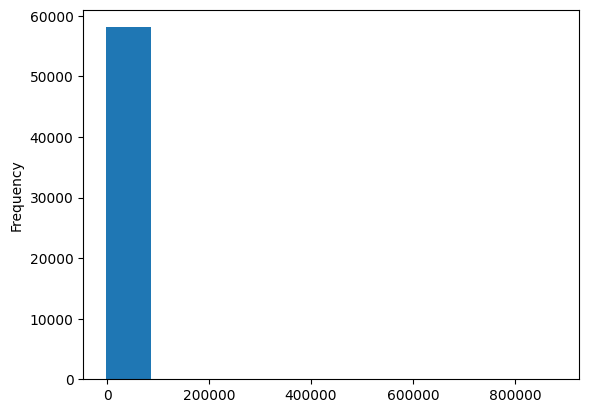

In [18]:
# column 6: 'cert_max_gr_wt'
col_metrics(ntsb_1, 'cert_max_gr_wt')
print(ntsb_1['cert_max_gr_wt'].max(), ntsb_1['cert_max_gr_wt'].min())

def weight_bins(df, col):
    avg_wt = df[col].mean()    
    wt_cat = []
    for x in list(df[col]):
        if x <= 12500:
            x = 'small'
            wt_cat.append(x)
        elif x > 12500 and x < 41000:
            x = 'medium'
            wt_cat.append(x)
        elif x == 'nan':
            if avg_wt <=12500:
                x = 'small'
                wt_cat.append(x)
            elif avg_wt > 12500 and x < 41000:
                x = 'medium'
                wt_cat.append(x)
            else:
                x = 'large commuter'
                wt_cat.append(x)
        else:
            x = 'large commuter'
            wt_cat.append(x)
    df[col] = wt_cat
    return df[col]

In [19]:
# use the bin function to assign categories to weight classes
ntsb_1['cert_max_gr_wt'] = weight_bins(ntsb_1, 'cert_max_gr_wt')

current df shape: (61575, 86)
Unique data:  [ 1.  2. nan  3.  4.  0.]
Value counts:  1.0    53204
2.0     7035
0.0      646
4.0       56
3.0       31
Name: num_eng, dtype: int64
Total nulls:  603
Data type:  float64


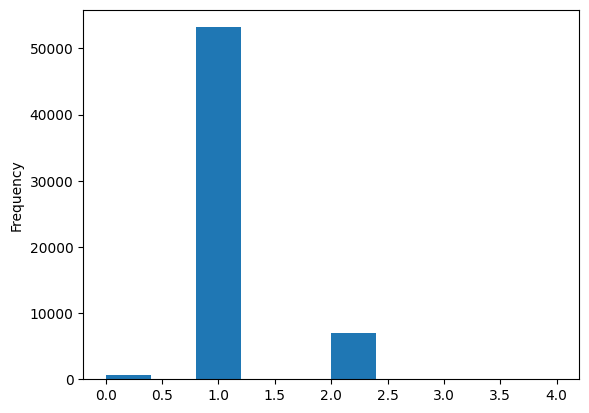

In [20]:
# column 7: 'num_eng'
col_metrics(ntsb_1, 'num_eng')

# convert the float to int and then impute the nulls with the median
ntsb_1['num_eng'] = ntsb_1['num_eng']

In [21]:
# change from float to int8
# fill na with 1
ntsb_1['num_eng'] = ntsb_1['num_eng'].fillna(1.0).astype('int8')


In [22]:
# column 8: 'type_last_insp'
col_metrics(ntsb_1, 'type_last_insp')
ntsb_1['type_last_insp'] = ntsb_1['type_last_insp'].fillna('unk')

current df shape: (61575, 86)
Unique data:  ['100h' 'aaip' 'annl' 'unk' 'coaw' 'cond' nan]
Value counts:  annl    35290
unk     10134
100h     9705
cond     1786
aaip     1706
coaw     1572
Name: type_last_insp, dtype: int64
Total nulls:  1382
Data type:  object


current df shape: (61575, 86)
Unique data:  [10286.  14424.      nan ...  2341.8    53.2   967.5]
Value counts:  1.0        138
3000.0     112
2500.0     102
2000.0     100
4000.0      91
          ... 
12746.0      1
12005.0      1
6072.0       1
4976.0       1
967.5        1
Name: afm_hrs, Length: 13518, dtype: int64
Total nulls:  12000
Data type:  float64


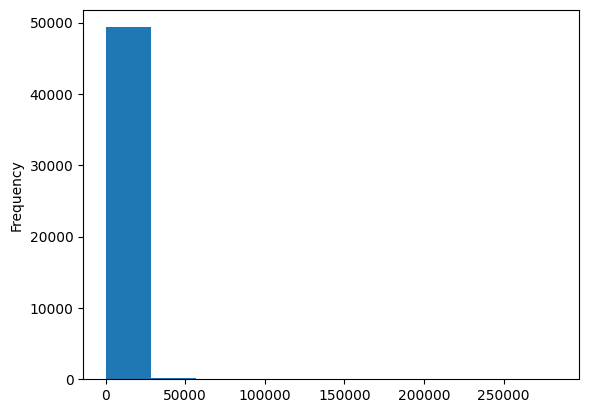

In [23]:
# column 9: 'afm_hrs'
col_metrics(ntsb_1, 'afm_hrs')

In [24]:
ntsb_1['afm_hrs'].describe()

count     49575.000000
mean       3644.943467
std        4666.852403
min           0.000000
25%        1271.000000
50%        2712.000000
75%        4564.500000
max      283334.000000
Name: afm_hrs, dtype: float64

In [25]:
# count how many values are outliers
outlier = (1.5*(4752 - 1229)) + 4752
outliers = [x for x in ntsb_1['afm_hrs'] if x > outlier]
print(len(outliers))

2457


In [26]:
# fill na with median
#median = ntsb_1['afm_hrs'].median()
#ntsb_1['afm_hrs'] = ntsb_1['afm_hrs'].fillna(median)
# drop the outliers
ntsb_1 = ntsb_1[ntsb_1['afm_hrs'] < outlier]


<Axes: ylabel='Frequency'>

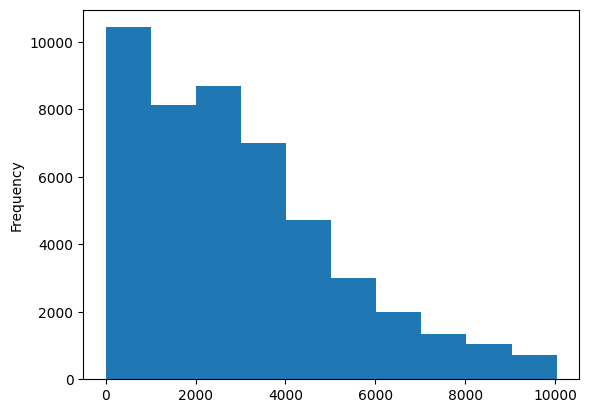

In [27]:
ntsb_1['afm_hrs'].plot.hist(bins=10)

In [28]:
ntsb_1.shape

(47118, 86)

In [29]:
# round and change to int32
ntsb_1['afm_hrs'] = ntsb_1['afm_hrs'].round().astype('int16')

In [30]:
# column 10: 'type_fly'
col_metrics(ntsb_1, 'type_fly')

current df shape: (47118, 86)
Unique data:  ['exec' 'pers' 'bus' 'inst' 'unk' 'pubu' 'posi' 'fery' 'owrk' 'aapl'
 'aobv' nan 'skyd' 'flts' 'asho' 'adrp' 'gldt' 'bant' 'pubf' 'publ' 'pubs'
 'exld' 'firf']
Value counts:  pers    29465
inst     6320
unk      2716
bus      2524
aapl     2487
posi      848
owrk      485
fery      467
exec      383
aobv      347
pubu      225
flts      209
skyd       74
asho       72
bant       48
gldt       19
pubs       12
publ        8
pubf        7
adrp        5
exld        5
firf        1
Name: type_fly, dtype: int64
Total nulls:  391
Data type:  object


In [31]:
# change the null to unknown
ntsb_1['type_fly'] = ntsb_1['type_fly'].fillna('unk')

In [32]:
# column 11: 'dprt_apt_id'
col_metrics(ntsb_1, 'dprt_apt_id')

# need to drop the 'k' from all 4 letter icao's
ntsb_1['dprt_apt_id'] = ntsb_1['dprt_apt_id'].astype('str').apply(lambda x: x[1:] if len(x) == 4 and x[0] == 'k' else x)

current df shape: (47118, 86)
Unique data:  ['gmu' 'ox8' nan ... 'skg' '62k' '38cl']
Value counts:  none    920
pvt     264
mri     171
c       168
apa     137
       ... 
02w       1
62d       1
eo2       1
hm01      1
38cl      1
Name: dprt_apt_id, Length: 7832, dtype: int64
Total nulls:  10842
Data type:  object


In [33]:
# column 12: 'dprt_city'
col_metrics(ntsb_1, 'dprt_city')

current df shape: (47118, 86)
Unique data:  ['greeneville' nan 'detroit city' ... 'new philadelphia' 'kalaeloa'
 'ishpeming']
Value counts:  anchorage       356
houston         153
las vegas       150
columbus        142
fairbanks       136
               ... 
kirkville         1
cicero            1
putman            1
belmar-farm.      1
ishpeming         1
Name: dprt_city, Length: 6969, dtype: int64
Total nulls:  10809
Data type:  object


In [34]:
# there are some city names that have commas and states after. remove those with commas
ntsb_1['dprt_city'] = ntsb_1['dprt_city'].str.split(',').str[0]


In [35]:
# column 13: 'dprt_state'
col_metrics(ntsb_1, 'dprt_state')

current df shape: (47118, 86)
Unique data:  ['sc' nan 'mi' 'mn' 'il' 'ks' 'mo' 'oh' 'ne' 'az' 'nm' 'tx' 'la' 'ok' 'in'
 'ca' 'me' 'or' 'ak' 'ga' 'co' 'nh' 'nv' 'fl' 'ma' 'de' 'pa' 'ct' 'ms'
 'al' 'nc' 'wy' 'tn' 'nj' 'hi' 'ky' 'vi' 'id' 'wa' 'ut' 'ar' 'va' 'pr'
 'ny' 'wv' 'mt' 'sd' 'nd' 'po' 'vt' 'dc' 'ri' 'ia' 'cd' 'md' 'wi' 'of'
 'gm' 'ah' 'cn' 'bc' 'mp' 'yt' 'mx' 'un' 'bh' 'ad' 'nb' 'pq' 'cb' 'gu'
 'ha' 'io' 'kn' 'ja' 'bi' 'ao' 'dr']
Value counts:  ca    4006
fl    2643
tx    2454
ak    2098
az    1298
co    1179
wa    1141
ga     999
mi     910
ny     897
oh     893
il     892
pa     873
nc     786
mo     728
or     714
wi     689
mn     668
va     629
id     608
in     589
nv     582
ar     575
nj     575
ut     574
tn     571
nm     571
al     545
ks     536
ok     525
sc     489
la     473
mt     429
ma     414
md     398
ia     382
ms     359
ne     332
ky     317
wy     309
me     266
nd     247
ct     241
sd     233
nh     190
hi     188
wv     187
vt     115
pr      92
ri    

In [36]:
# print out all the states that are incorrect
state_abbr = [
    "AL",  # Alabama
    "AK",  # Alaska
    "AZ",  # Arizona
    "AR",  # Arkansas
    "CA",  # California
    "CO",  # Colorado
    "CT",  # Connecticut
    "DE",  # Delaware
    "FL",  # Florida
    "GA",  # Georgia
    "HI",  # Hawaii
    "ID",  # Idaho
    "IL",  # Illinois
    "IN",  # Indiana
    "IA",  # Iowa
    "KS",  # Kansas
    "KY",  # Kentucky
    "LA",  # Louisiana
    "ME",  # Maine
    "MD",  # Maryland
    "MA",  # Massachusetts
    "MI",  # Michigan
    "MN",  # Minnesota
    "MS",  # Mississippi
    "MO",  # Missouri
    "MT",  # Montana
    "NE",  # Nebraska
    "NV",  # Nevada
    "NH",  # New Hampshire
    "NJ",  # New Jersey
    "NM",  # New Mexico
    "NY",  # New York
    "NC",  # North Carolina
    "ND",  # North Dakota
    "OH",  # Ohio
    "OK",  # Oklahoma
    "OR",  # Oregon
    "PA",  # Pennsylvania
    "RI",  # Rhode Island
    "SC",  # South Carolina
    "SD",  # South Dakota
    "TN",  # Tennessee
    "TX",  # Texas
    "UT",  # Utah
    "VT",  # Vermont
    "VA",  # Virginia
    "WA",  # Washington
    "WV",  # West Virginia
    "WI",  # Wisconsin
    "WY",  # Wyoming
    'gu', 
    'mp', 
    'pr',
    'tt',
    'vi'
]
print(len(state_abbr))
state_abbr = list(map(str.lower, state_abbr))

55


In [37]:
# incorrect states
wrong_states = set()
state_sum = []
for x in ntsb_1['dprt_state']:
  if (x not in state_abbr) and (x is not np.nan):
      wrong_states.add(x)
      state_sum.append(x)
print(len(state_sum))
print(wrong_states)

# drop the rows with incorrect state values
ntsb_1 = ntsb_1[~ntsb_1['dprt_state'].isin(wrong_states)]

222
{'gm', 'yt', 'nb', 'io', 'dr', 'ad', 'cd', 'mx', 'ah', 'cb', 'cn', 'dc', 'po', 'un', 'bh', 'kn', 'ao', 'ha', 'bi', 'pq', 'of', 'ja', 'bc'}


In [38]:
ntsb_1.shape

(46896, 86)

current df shape: (46896, 86)
Unique data:  [ 908. 1710. 1200. ...  156.   29.  322.]
Value counts:  0.0       3934
1400.0     914
1500.0     862
1600.0     774
1300.0     744
          ... 
749.0        1
157.0        1
80.0         1
2346.0       1
322.0        1
Name: dprt_time, Length: 1359, dtype: int64
Total nulls:  1615
Data type:  float64


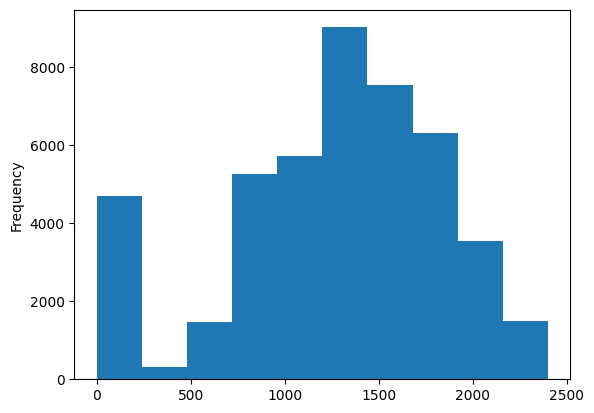

In [39]:
# column 14: 'dprt_time'
col_metrics(ntsb_1, 'dprt_time')

In [40]:
# change to string
ntsb_1['dprt_time'] = ntsb_1['dprt_time'].astype('str')

# remove all .o
ntsb_1['dprt_time'] = ntsb_1['dprt_time'].str.rstrip('.0')
times = []
for x in list(ntsb_1['dprt_time']):
    if len(x) == 1:
        x = '000' + x
        times.append(x)
    elif len(x) == 2:
        x = '00' + x
        times.append(x)
    elif len(x) == 3:
        x = '0' + x
        times.append(x)
    else:
        times.append(x)
ntsb_1['dprt_time'] = times
ntsb_1['dprt_time'].unique()


array(['0908', '0171', '0012', ..., '0156', '0029', '0322'], dtype=object)

In [41]:
import numpy as np
# column 15: 'dest_same_local'
col_metrics(ntsb_1, 'dest_same_local')

# three different versions of yes so standatdizing it
ntsb_1['dest_same_local'] = ntsb_1['dest_same_local'].str.replace('same', 'y').str.replace('locl', 'y').str.replace('spec', 'y')

ntsb_1.loc[ntsb_1['dest_same_local'] == 'y', 'dest_apt_id'] = ntsb_1['dest_apt_id'].fillna(ntsb_1['dprt_apt_id'])  
 

current df shape: (46896, 86)
Unique data:  ['same' 'locl' nan 'spec' 'y']
Value counts:  locl    15244
same     9750
spec       19
y           1
Name: dest_same_local, dtype: int64
Total nulls:  21882
Data type:  object


In [42]:
# column 16: 'dest_apt_id'
col_metrics(ntsb_1, 'dest_apt_id')

# need to drop the 'k' from all 4 letter icao's
ntsb_1['dest_apt_id'] = ntsb_1['dest_apt_id'].astype('str').apply(lambda x: x[1:] if len(x) == 4 and x[0] == 'k' else x)
ntsb_1.loc[ntsb_1['dest_apt_id'] == 'c', 'dest_apt_id'] = ntsb_1['dest_apt_id'].str.replace('c', 'pvt')

current df shape: (46896, 86)
Unique data:  ['3a1' 'ox8' 'nan' ... 'vvs' '62k' '38cl']
Value counts:  nan     6700
none     953
pvt      281
c        206
mri      178
        ... 
wa39       1
odk        1
ibk        1
1ha        1
38cl       1
Name: dest_apt_id, Length: 7859, dtype: int64
Total nulls:  3049
Data type:  object


In [43]:
# col 17: 'dest_city'
col_metrics(ntsb_1, 'dest_city')

# there are some city names that have commas and states after. remove those with commas
ntsb_1['dest_city'] = ntsb_1['dest_city'].str.split(',').str[0]

current df shape: (46896, 86)
Unique data:  [nan 'oklahoma city' 'mt. vernon' ... 'langley' 'hicks/fort wort'
 'detroit/grosse ile']
Value counts:  anchorage             203
las vegas             122
houston               110
atlanta                99
phoenix                97
                     ... 
miamisburg              1
la cholla (pvt)         1
ranger creek            1
jack edwards            1
detroit/grosse ile      1
Name: dest_city, Length: 5920, dtype: int64
Total nulls:  20172
Data type:  object


In [44]:
# column 18: 'dest_state'
col_metrics(ntsb_1, 'dest_state')

# incorrect states
wrong_states = set()
state_sum = []
for x in ntsb_1['dest_state']:
  if (x not in state_abbr) and (x is not np.nan):
      wrong_states.add(x)
      state_sum.append(x)
print(len(state_sum))
print(wrong_states)

# drop the rows with incorrect state values
ntsb_1 = ntsb_1[~ntsb_1['dest_state'].isin(wrong_states)]

current df shape: (46896, 86)
Unique data:  ['al' nan 'ok' 'il' 'ks' 'co' 'ar' 'ne' 'tx' 'ca' 'fl' 'pa' 'mi' 'az' 'nv'
 'sc' 'ms' 'ct' 'ak' 'ia' 'ut' 'oh' 'tn' 'nc' 'mn' 'mo' 'nm' 'ga' 'or'
 'of' 'la' 'nj' 'ky' 'pr' 'wa' 'wy' 'nh' 'va' 'me' 'ma' 'cg' 'p1' 'id'
 'mt' 'in' 'wi' 'md' 'ny' 'wv' 'ck' 'hi' 'gm' '42' 'vt' 'de' 'nd' 'no'
 'ap' 'mx' 'ri' 'bc' 'cd' 'bm' 'dc' 'fm' 'fi' 'bu' 'go' 'vn' 'fd' 'cn'
 'ws' 'sd' 'vi' 'nb' 'un' 'dl' 'gc' '0' 'on' 'a' 'cb' '2' 'gu' 'it' 'd'
 '\x11' 'ao']
Value counts:  ca    2929
fl    1958
tx    1856
ak    1568
az     960
co     884
wa     855
ga     739
ny     664
oh     633
nc     629
mi     621
pa     620
il     613
or     563
mo     529
id     508
wi     505
mn     489
tn     461
va     456
ut     449
nv     444
in     435
nm     430
al     422
nj     405
ok     404
ar     384
ks     384
sc     377
mt     343
la     333
ma     328
ia     296
md     270
ky     242
ne     238
ms     237
wy     233
me     206
ct     187
nd     162
sd     160
wv     154
h

current df shape: (46748, 86)
Unique data:  [560. 520. 540. 570. 580. 530. 550. 510. 590. 553. 574. 569. 565. 522.
 541. 551. 572. 564. 400. 568. 571.  nan 573. 531. 561. 581. 563. 582.
 552. 512. 513. 583. 521. 567. 566. 523. 562. 575. 576. 591. 511. 592.
 542. 514.]
Value counts:  570.0    14302
520.0     4904
580.0     3343
550.0     3322
560.0     2764
540.0     2684
510.0      913
572.0      805
574.0      748
522.0      652
530.0      607
571.0      552
564.0      220
590.0      209
576.0      190
521.0      175
565.0      172
553.0      152
541.0      139
581.0       93
573.0       90
523.0       81
531.0       68
513.0       60
575.0       55
561.0       50
552.0       46
567.0       45
563.0       39
551.0       39
512.0       38
569.0       32
582.0       26
583.0       22
591.0       21
562.0       19
566.0       14
568.0       12
592.0       11
514.0        4
400.0        1
511.0        1
542.0        1
Name: phase_flt_spec, dtype: int64
Total nulls:  9027
Data type:  float

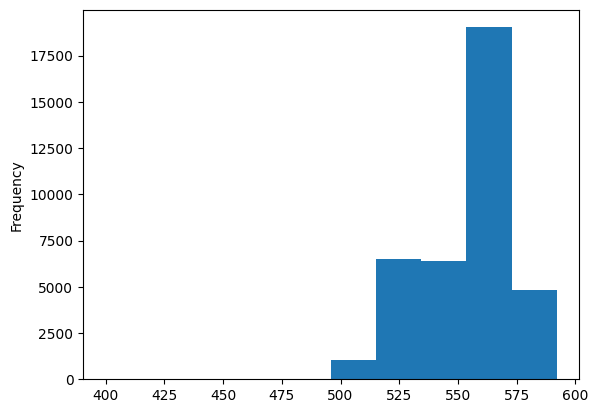

In [45]:
# col 19: phase_flt_spec
col_metrics(ntsb_1, 'phase_flt_spec')

In [46]:
# col 20: afm_hrs_since
col_metrics(ntsb_1, 'afm_hrs_since')

current df shape: (46748, 86)
Unique data:  [nan 'insp' 'acci' 'n' 'y']
Value counts:  n       4570
y       4372
acci    4336
insp    2046
Name: afm_hrs_since, dtype: int64
Total nulls:  31424
Data type:  object


In [47]:
ntsb_1.columns

Index(['aircraft_ev_id', 'far_part', 'flight_plan_activated', 'damage',
       'acft_make', 'acft_model', 'cert_max_gr_wt', 'num_eng',
       'type_last_insp', 'date_last_insp', 'afm_hrs_last_insp', 'afm_hrs',
       'type_fly', 'dprt_apt_id', 'dprt_city', 'dprt_state', 'dprt_time',
       'dest_same_local', 'dest_apt_id', 'dest_city', 'dest_state',
       'phase_flt_spec', 'afm_hrs_since', 'rwy_num', 'rwy_len', 'rwy_width',
       'ifr_equipped_cert', 'eng_no', 'eng_type', 'eng_mfgr', 'hp_or_lbs',
       'carb_fuel_injection', 'eng_time_total', 'eng_time_last_insp',
       'ntsb_no', 'ev_type', 'ev_date', 'ev_dow', 'ev_time', 'ev_city',
       'ev_state', 'ev_year', 'ev_month', 'latitude', 'longitude', 'apt_name',
       'ev_nr_apt_id', 'ev_nr_apt_loc', 'apt_dist', 'apt_dir', 'apt_elev',
       'wx_src_iic', 'wx_obs_time', 'wx_obs_dir', 'wx_obs_fac_id',
       'wx_obs_elev', 'wx_obs_dist', 'light_cond', 'sky_cond_nonceil',
       'sky_nonceil_ht', 'sky_ceil_ht', 'sky_cond_ceil', 'vis_

In [48]:
ntsb_2 = ntsb_1

## Kathleen Section

In [49]:
ntsb_2.columns

Index(['aircraft_ev_id', 'far_part', 'flight_plan_activated', 'damage',
       'acft_make', 'acft_model', 'cert_max_gr_wt', 'num_eng',
       'type_last_insp', 'date_last_insp', 'afm_hrs_last_insp', 'afm_hrs',
       'type_fly', 'dprt_apt_id', 'dprt_city', 'dprt_state', 'dprt_time',
       'dest_same_local', 'dest_apt_id', 'dest_city', 'dest_state',
       'phase_flt_spec', 'afm_hrs_since', 'rwy_num', 'rwy_len', 'rwy_width',
       'ifr_equipped_cert', 'eng_no', 'eng_type', 'eng_mfgr', 'hp_or_lbs',
       'carb_fuel_injection', 'eng_time_total', 'eng_time_last_insp',
       'ntsb_no', 'ev_type', 'ev_date', 'ev_dow', 'ev_time', 'ev_city',
       'ev_state', 'ev_year', 'ev_month', 'latitude', 'longitude', 'apt_name',
       'ev_nr_apt_id', 'ev_nr_apt_loc', 'apt_dist', 'apt_dir', 'apt_elev',
       'wx_src_iic', 'wx_obs_time', 'wx_obs_dir', 'wx_obs_fac_id',
       'wx_obs_elev', 'wx_obs_dist', 'light_cond', 'sky_cond_nonceil',
       'sky_nonceil_ht', 'sky_ceil_ht', 'sky_cond_ceil', 'vis_

In [50]:
#Walkthrough at https://inria.github.io/scikit-learn-mooc/python_scripts/03_categorical_pipeline_column_transformer.html
#preprocessing different for categorical vs numerical columns

from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(ntsb_raw)
categorical_columns = categorical_columns_selector(ntsb_raw)

In [51]:
#print(df.columns[2])
col_list = ntsb_2.columns[23:46]
print(col_list)

Index(['rwy_num', 'rwy_len', 'rwy_width', 'ifr_equipped_cert', 'eng_no',
       'eng_type', 'eng_mfgr', 'hp_or_lbs', 'carb_fuel_injection',
       'eng_time_total', 'eng_time_last_insp', 'ntsb_no', 'ev_type', 'ev_date',
       'ev_dow', 'ev_time', 'ev_city', 'ev_state', 'ev_year', 'ev_month',
       'latitude', 'longitude', 'apt_name'],
      dtype='object')


rwy_num
current df shape: (46748, 86)
Unique data:  ['20' '36' '18' '32' '27' '0' '35' '16' '26r' '28' '4r' '17' '34' '14'
 '22' '28l' '15l' '11r' '17l' '13' '24' '10l' '9' '30r' '15' '26' '21r'
 '3' '9r' '25' '1r' '5r' '7' '4' '12' '3r' '31' '5' '29' '29r' '19' '21'
 '8' '10' '23' '19l' '33' '30' '2' '28r' '1' '6' '26l' '14r' '17r' '19r'
 '25r' '11' '35r' '12r' '6l' '2l' '18r' '32r' '36l' '27r' '8r' '34r' '29l'
 '22l' '31r' '22g' '20r' '27l' '11l' '8l' '22r' '34l' '1l' '16l' '16r'
 '9l' '23r' '5l' '18l' '20l' '7r' '13l' '13r' '25l' '23l' '24l' '35l'
 '21l' '24r' '30l' '31l' '12l' '20c' '7l' '33l' '30c' '36c' '32l' '23c'
 '17c' '36r' '3l' nan '3c' '2r' '33r' '15r' '4l' '10r' '360' '14l' '190'
 '250' '01' '02' '067' '09' '05' '2c' '06' '6r' '0r' '00' '202' '61' '04'
 'nw' '03' '315' '07' '08' 'unk' '090' 'h1' '210' '160' '7u' '080' '27u'
 '180' '09r' '040' '055' '350' '070' '030' '010' '01l' '050' '270' 's'
 '09l' '5r7' '135' '9c' 'afo' 'gif' 'emm' '280' '110' '290' '240' '320'
 '020' '

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


eng_time_last_insp
current df shape: (46748, 86)
Unique data:  [      nan 0.000e+00 7.000e+00 3.000e+01 9.000e+01 4.000e+00 1.000e+00
 6.000e+00 1.800e+01 8.000e+00 2.400e+01 1.100e+01 3.500e+01 1.790e+02
 5.700e+01 4.200e+01 3.000e+00 9.000e+00 2.800e+01 8.400e+01 1.004e+03
 7.500e+01 2.000e+01 2.000e+00 3.600e+01 5.800e+01 1.200e+01 7.100e+01
 3.900e+01 1.360e+02 8.900e+01 3.400e+01 1.500e+01 6.100e+01 1.340e+02
 1.000e+01 5.400e+01 1.840e+02 2.100e+01 6.815e+03 7.200e+01 2.010e+03
 4.700e+01 7.300e+01 5.950e+02 1.410e+02 4.600e+01 9.700e+01 2.500e+01
 1.600e+01 4.300e+01 6.800e+01 2.600e+01 5.600e+01 9.400e+01 5.000e+01
 6.700e+01 5.000e+00 4.800e+01 1.700e+01 1.350e+02 3.300e+01 6.000e+01
 6.600e+01 5.500e+01 1.400e+01 1.300e+01 2.000e+02 3.560e+02 1.000e+02
 3.700e+01 3.800e+01 2.300e+01 6.300e+01 3.200e+01 3.100e+01 5.136e+03
 3.540e+02 5.200e+01 6.200e+01 1.500e+02 4.900e+01 9.900e+01 8.200e+01
 2.900e+01 8.800e+01 5.100e+01 2.790e+02 1.100e+02 4.100e+01 1.200e+02
 5.590e+02 8.3

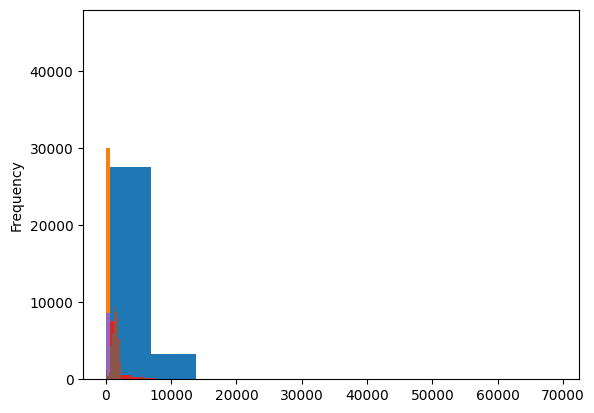

In [52]:
# Listing metrics for all assigned columns 

for col in col_list:
  print(ntsb_2[col].name)
  col_metrics(ntsb_2, col) 

In [53]:
# Removing spaces in runway number column. Not sure what else to do with this column, some runways might be more risky for particular airports, so I think this is valuable to keep.
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '0', '36', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '3 r', '3r', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '10r/', '10r', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '18r/', '18r', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '18 /', '18', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'unk', np.nan, inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'none', np.nan, inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '055', '55', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '000', '36', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '060' , '60', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '035', '35', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '07/2', '07', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '03/2', '03', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '08/2', '08', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '022', '22', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '9 r', '09r', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '2/8', '02', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '09/2', '09', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '04/2', '04', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '05/2', '05', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '12/3', '12', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '14/3', '14', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '15/3', '15', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '10/2', '10', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '11/2', '11', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '16/3', '16', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '18/3', '18', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '17/3', '17', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '02/2', '02', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '5/23', '05', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '9/27', '09', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '7/25', '07', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '1/19', '01', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'n', '36', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 's', '18', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'w', '27', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'e', '09', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'e/w', '27', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'n/s', '18', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'nw', '31', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'emm', np.nan, inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'afo', np.nan, inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'gif', np.nan, inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'pvt', 'private', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'se', '13', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'vgt', np.nan, inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'west', '27', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'ne', '04', inplace=True) 
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'vgt', np.nan, inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'sw', '24', inplace=True)
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == 'h2', np.nan, inplace=True)

In [54]:
## update runway numbers
ntsb_2['rwy_num'].mask(ntsb_2['rwy_num'] == '', np.nan, inplace=True)
ntsb_2['rwy_num'].unique()

array(['20', '36', '18', '32', '27', '35', '16', '26r', '28', '4r', '17',
       '34', '14', '22', '28l', '15l', '11r', '17l', '13', '24', '10l',
       '9', '30r', '15', '26', '21r', '3', '9r', '25', '1r', '5r', '7',
       '4', '12', '3r', '31', '5', '29', '29r', '19', '21', '8', '10',
       '23', '19l', '33', '30', '2', '28r', '1', '6', '26l', '14r', '17r',
       '19r', '25r', '11', '35r', '12r', '6l', '2l', '18r', '32r', '36l',
       '27r', '8r', '34r', '29l', '22l', '31r', '22g', '20r', '27l',
       '11l', '8l', '22r', '34l', '1l', '16l', '16r', '9l', '23r', '5l',
       '18l', '20l', '7r', '13l', '13r', '25l', '23l', '24l', '35l',
       '21l', '24r', '30l', '31l', '12l', '20c', '7l', '33l', '30c',
       '36c', '32l', '23c', '17c', '36r', '3l', nan, '3c', '2r', '33r',
       '15r', '4l', '10r', '360', '14l', '190', '250', '01', '02', '067',
       '09', '05', '2c', '06', '6r', '0r', '00', '202', '61', '04', '03',
       '315', '07', '08', '090', 'h1', '210', '160', '7u', '08

current df shape: (46748, 86)
Unique data:  [5500. 3800. 1900. ... 3354. 2141. 4651.]
Value counts:  0.0       5018
5000.0    1072
3000.0     961
4000.0     822
2500.0     523
          ... 
6272.0       1
4779.0       1
3173.0       1
2248.0       1
4651.0       1
Name: rwy_len, Length: 2971, dtype: int64
Total nulls:  15937
Data type:  float64


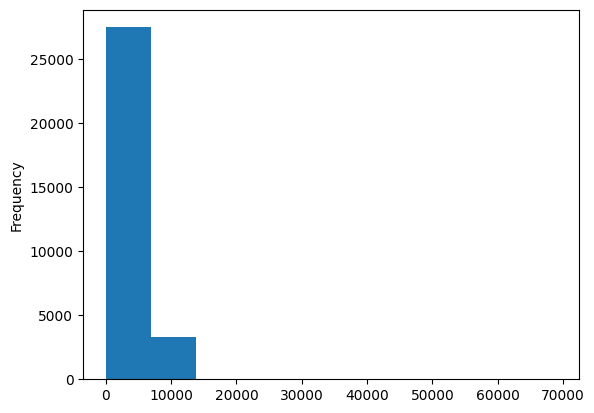

In [55]:
col_metrics(ntsb_2, col='rwy_len')

<Axes: ylabel='Density'>

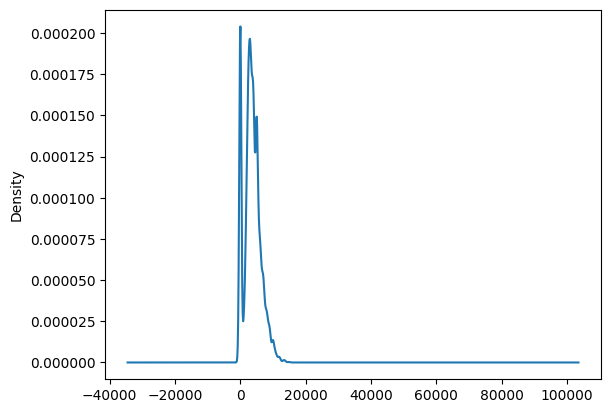

In [56]:
ntsb_2['rwy_len'].plot(kind='kde')

In [57]:
# binning values in 'rwy_len' column

bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000]
labels =[1,2,3,4,5,6,7,8,9,10,11,12]
ntsb_2['rwy_len'] = pd.cut(ntsb_2['rwy_len'], bins,labels=labels)
col_metrics(ntsb_2, col='rwy_len')

current df shape: (46748, 86)
Unique data:  [6, 4, 2, 7, NaN, ..., 9, 8, 11, 12, 1]
Length: 13
Categories (12, int64): [1 < 2 < 3 < 4 ... 9 < 10 < 11 < 12]
Value counts:  3     5762
4     5509
5     4212
6     3160
2     2034
7     1835
8     1222
9      835
10     441
1      319
11     257
12     122
Name: rwy_len, dtype: int64
Total nulls:  21040
Data type:  category


In [58]:
# count how many values are outliers
outlier = (1.5*(4752 - 1229)) + 4752
outliers = [x for x in ntsb_2['afm_hrs'] if x > outlier]
print(len(outliers))

0


current df shape: (46748, 86)
Unique data:  [1.000e+02 3.600e+01 7.500e+01 1.500e+02 1.200e+02       nan 5.000e+01
 6.000e+01 3.000e+02 8.000e+01 4.000e+01 1.530e+02 7.200e+01 9.000e+01
 3.000e+01 4.500e+01 3.500e+01 1.590e+02 7.000e+01 7.300e+01 4.400e+01
 6.500e+01 4.700e+01 6.600e+01 2.000e+02 1.300e+02 2.500e+01 4.800e+01
 2.600e+01 5.500e+01 6.800e+01 1.600e+02 3.900e+01 4.300e+01 3.200e+01
 2.400e+01 1.700e+02 2.500e+02 2.200e+01 4.200e+01 1.250e+02 5.000e+02
 2.000e+01 5.900e+01 7.700e+01 2.800e+01 1.800e+02 1.500e+01 2.090e+02
 7.400e+01 3.800e+01 2.900e+02 1.150e+02 8.500e+01 3.700e+01 1.400e+02
 1.100e+02 0.000e+00 1.900e+02 1.750e+02 3.400e+01 1.010e+02 7.800e+01
 6.200e+01 3.100e+01 1.350e+02 6.100e+01 4.900e+01 1.880e+02 1.800e+01
 1.000e+01 2.150e+02 1.450e+02 9.500e+01 1.140e+02 2.400e+02 4.600e+01
 1.130e+02 1.200e+01 3.300e+01 1.480e+02 2.300e+02 4.000e+02 9.600e+01
 2.800e+02 2.020e+02 8.400e+01 2.600e+02 2.700e+01 1.040e+02 1.050e+02
 1.160e+02 9.400e+01 5.600e+01 2.

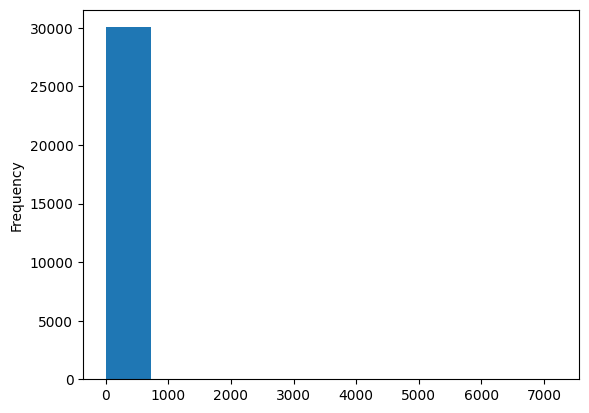

In [59]:
col_metrics(ntsb_2, col='rwy_width')

In [60]:
ntsb_2['rwy_width'].round(0)

3         100.0
5          36.0
6          75.0
7         150.0
8         120.0
          ...  
104049      NaN
104061     50.0
104078      NaN
104092      NaN
104119      NaN
Name: rwy_width, Length: 46748, dtype: float64

In [61]:
ntsb_2['rwy_width'].max()

7201.0

<Axes: ylabel='Density'>

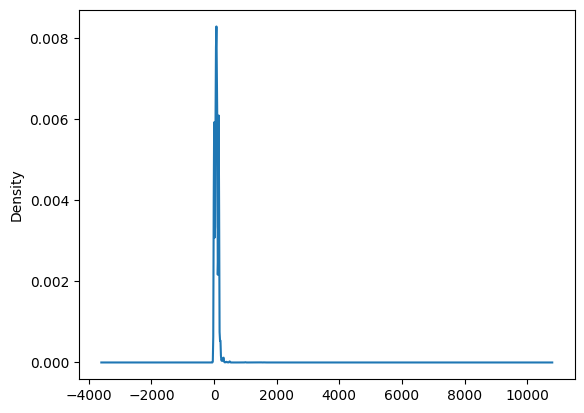

In [62]:
ntsb_2['rwy_width'].plot(kind='kde')

In [63]:
# binning values in 'rwy_width' column... same question as above

bins2 = [0,10,20,30,40,50,60,70,80,90,100,200]
labels2 = [1,2,3,4,5,6,7,8,9,10,11,]

#bins2 = [0, 100, 200, 300, 400, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000]
#labels2 =[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
ntsb_2['rwy_width'] = pd.cut(ntsb_2['rwy_width'], bins2, labels=labels2)
col_metrics(ntsb_2, col='rwy_width')

current df shape: (46748, 86)
Unique data:  [10, 4, 8, 11, NaN, ..., 9, 3, 7, 2, 1]
Length: 12
Categories (11, int64): [1 < 2 < 3 < 4 ... 8 < 9 < 10 < 11]
Value counts:  11    6577
8     5271
10    5107
5     2837
6     1975
4     1051
3      720
7      511
2      220
9      149
1       17
Name: rwy_width, dtype: int64
Total nulls:  22313
Data type:  category


In [64]:
col_metrics(ntsb_2, col='eng_type')

current df shape: (46748, 86)
Unique data:  ['tp' 'rec' 'tj' 'ts' 'unk' 'tf' nan 'elec' 'none' 'hr']
Value counts:  rec     42391
ts       1471
tp       1383
unk       556
tf        298
tj        178
none        5
elec        3
hr          1
Name: eng_type, dtype: int64
Total nulls:  462
Data type:  object


In [65]:
# Changing datatype for eng_type column to category
ntsb_2['eng_type'].astype('category')

3          tp
5         rec
6         rec
7         rec
8         rec
         ... 
104049    rec
104061    rec
104078    rec
104092    rec
104119     tp
Name: eng_type, Length: 46748, dtype: category
Categories (9, object): ['elec', 'hr', 'none', 'rec', ..., 'tj', 'tp', 'ts', 'unk']

In [66]:
#replacing none and unk values from eng_type with nan
ntsb_2['eng_type'].mask(ntsb_2['eng_type'] == 'none', np.nan, inplace=True)
ntsb_2['eng_type'].mask(ntsb_2['eng_type'] == 'unk', np.nan, inplace=True)

In [67]:
ntsb_2['eng_mfgr'].unique()

array(['p&w', 'lycoming', 'continental', 'garrett', 'jacobs', 'allison',
       'rotax', 'turbomeca', nan, 'walter', 'franklin', 'pzl-kalisz',
       'hirth', 'volkswagen', 'rotorway', 'subaru', 'unknown',
       'revmaster', 'p&w canada', 'bombardier', 'gansheimer', 'ge',
       'wright', 'grob', 'china', 'mazda', 'fairchild', 'kinner',
       'curtis wright', 'great plains', 'hapi', 'cameron', 'rolls-royce',
       'pezetel', 'onan', 'hirtmotoren', 'milwaukee prt', 'zenoah',
       'jaguar', 'packard', 'vendeneyev', 'chevrolet', 'kawasaki',
       'mcculloch', 'cuyuna', 'kfm', 'pzl mielec', 'warner', 'lambert',
       'nsi', 'amw', 'voronezh', 'ford', 'jpx', 'bmw r-r', 'wsk',
       'shvetsov', 'honda', 'allied signal', 'housia', 'microal',
       'limbach', 'spencer', 'klimov', 'konig', 'mosler', 'orenda',
       'emsa', 'detr. diesel', 'lom', 'bristol', 'airesearch',
       'teledyne cont', 'jabiru', 'yamaha', 'thruct in', 'suzuki',
       'falconer eng.', 'solo', 'volvo', 'velie',

In [68]:
ntsb_2.drop(columns=['hp_or_lbs', 'ntsb_no'])

,aircraft_ev_id,far_part,flight_plan_activated,damage,acft_make,acft_model,cert_max_gr_wt,num_eng,type_last_insp,date_last_insp,...,inj_tot_t,wx_cond_basic,Cause_Factor,crew_no,crew_category,crew_age,crew_sex,med_certf,pilot_flying,crew_inj_level
3,20001204x00006,091,NaN,dest,beech,other_model,medium,2,aaip,1/14/1999,...,2.0,imc,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
5,20001204x00008,091,NaN,dest,aero commander,other_model,small,2,annl,10/1/1998,...,4.0,vmc,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
6,20001204x00015,091,NaN,subs,gettis h. hudson,other_model,small,1,annl,8/1/1998,...,NaN,vmc,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
7,20001204x00016,091,NaN,dest,beech,other_model,small,2,annl,6/22/1998,...,3.0,imc,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
8,20001204x00017,091,NaN,dest,beech,other_model,small,2,annl,11/4/1998,...,3.0,imc,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104049,20160721x52728,091,n,subs,boeing,other_model,small,1,annl,10-dec-15,...,2.0,vmc,NaN,2.0,pass,NaN,f,NaN,True,minr
104061,20160721x55442,091,n,subs,rockwell international,other_model,small,1,annl,25-may-16,...,3.0,vmc,c,3.0,pass,NaN,m,NaN,True,none
104078,20160721x90029,137,n,subs,grumman acft eng cor-schweizer,other_model,small,1,100h,23-jun-16,...,1.0,vmc,c,1.0,plt,29.0,m,cl2,True,none
104092,20160722x63338,091,y,dest,vans,other_model,large commuter,1,cond,16-jun-16,...,2.0,vmc,c,2.0,pass,84.0,f,NaN,True,fatl


In [69]:
#Cleaning names of engine manufacturers.

ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == '1/2 volkswagen', 'volkswagen', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'aero engines (vw)', 'volkswagen', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == '4 burner type engines', '', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'ã\x80/o', '', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'â\x82¬', '', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'aero engines (vw)', 'aero engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'aero sport', 'aero sport power', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'aero sport power (lycoming)', 'lycoming', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'aero sport power (lycoming)', 'aero sport power', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'aero sport power ltd', 'aero sport power', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'aero sport power ltd.', 'aero sport power', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'aero-vee', 'aero vee', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'aeromotors s.a.', 'aero motors', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'aerosport', 'aero sport power', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'aerosport / lycoming', 'lycoming', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'aerosport / lycoming', 'aero sport power', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'aerosport power', 'aero sport power', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'aerovee', 'aero vee', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'ai', 'airesearch', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'aireasearch', 'airesearch', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'aireaserch/garrett', 'garrett', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'aireaserch/garrett', 'airesearch', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'airresearch', 'airesearch', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'airresearch/honeywell', 'honeywell aerospace', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'airresearch/honeywell', 'airesearch', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'allied', 'allied signal', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'allied/honeyw', 'honeywell aerospace', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'allied/honeyw', 'allied signal', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'alliedsignal', 'allied signal', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'allison (r/r)', 'rolls-royce', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'allison (r/r)', 'allison', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'allison / rolls royce', 'rolls-royce', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'allison / rolls royce', 'allison', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'allison 250-c20b', 'allison', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'allison c', 'allison', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'allison engine', 'allison', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'allison rolls royce', 'rolls-royce', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'allison rolls royce', 'allison', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'allison/rolls royce', 'rolls-royce', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'allison/rolls royce', 'allison', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'allison/rolls-royce', 'rolls-royce', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'allison/rolls-royce', 'allison', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'allison/rr', 'rolls-royce', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'allison/rr', 'allison', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'alllison', 'allison', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'ama (vw)', 'volkswagen', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'ama/expr', 'ama', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'ama/expr lycoming)', 'lycoming', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'ama/expr lycoming', 'ama', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'arriel', 'safran helicopter engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'ariel', 'safran helicopter engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'avco', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'avco lycoming', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'barrett precision engines', 'barret precision engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'barrett performance engine', 'barret precision engines', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'bmw r-r', 'rolls-royce', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'bmw r-r', 'bmw', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'bmw rolls-royce', 'rolls-royce', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'bmw rolls-royce', 'bmw', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'bombardier', 'brp-rotax', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'bombardier rotax', 'brp-rotax', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'bombardier rotex', 'brp-rotax', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'bombardier-rotax', 'brp-rotax', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'bombardier', 'brp-rotax', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'bombardier/rotax', 'brp-rotax', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'bristsidviper', 'Armstrong Siddeley', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'brp rotax gmbh7 co. kg', 'brp-rotax', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'cfm', 'cfm international', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'cfm intl', 'cfm international', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'cfm intl.', 'cfm international', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'chapallal', 'elroy air chaparral', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'chevrolet corvair', 'chevrolet', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'chevrolot', 'chevrolet', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'chevy', 'chevrolet', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'chevy geo metro', 'chevrolet', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'club crafters inc.', 'club crafters, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'compact ra', 'compact radial engines, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'compact radial engines', 'compact radial engines, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'compact radial engines inc.', 'compact radial engines, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'continental motor\'s inc', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'conintental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'conitnental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'cont motor', 'continental motors, inc.', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'cont motor p. ponk', 'p.ponk', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'cont motor p. ponk', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'cont motor/perf eng', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'cont-motor', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'cont. motor', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'contenental teledyne', 'teledyne turbine engines', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental teledyne', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenintal', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contenental', 'continental motors, inc.', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'continental teledyne motors', 'teledyne turbine engines', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'continental teledyne motors', 'continental motors, inc.', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'continental/p. ponk', 'p.ponk', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'continental/p. ponk', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'continential', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'continential motors', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'continetal motors', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'continetnal', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contintental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contl', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'contnental', 'continental motors, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'corvair', 'chevrolet', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'covington', 'covington aircraft engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'cub crafter', 'club crafters, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'cub crafters', 'club crafters, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'cubcrafters', 'club crafters, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'curtis - wright', 'curtiss-wright', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'curtis wright', 'curtiss-wright', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'curtis-wright', 'curtiss-wright', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'curtiss', 'curtiss-wright', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'curtiss wright', 'curtiss-wright', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'curtiswright', 'curtiss-wright', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'custom', np.nan, inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'cuyana', 'cuyuna', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'dehav eng', 'de havilland', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'dehavilland', 'de havilland', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'detr. diesel', 'detroit diesel', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'diamond', 'diamond aircraft', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'diemech', 'diemech turbines', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'diemech (walter)', 'walter aircraft engines', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'diemech (walter)', 'diemech turbines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'diemech turbine', 'diemech turbines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'diemech turbines inc', 'diemech turbines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'eci', 'engine components, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'eci titan', 'engine components, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'eci/titan', 'engine components, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'eggenfellner', 'eggenfellner aircraft, inc.', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'eggenfellner subaru', 'subaru', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'eggenfellner subaru', 'eggenfellner aircraft, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'elizalde, s.a.', 'elizalde', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'engine components internationa', 'engine components international', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'engineair', 'engineair power systems', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'exp', 'experimental', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'experimental tcm', 'experimental', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'falconer', 'ryan falconer racing engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'falconer eng.', 'ryan falconer racing engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'frankin', 'franklin aircraft engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'franklin', 'franklin aircraft engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'franklyn', 'franklin aircraft engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'frnklin', 'franklin aircraft engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'g e', 'general electric', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'garett', 'garret', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'garret airesearch', 'airesearch', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'garret airesearch', 'garret', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'garret/honeywell', 'honeywell aerospace', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'garret/honeywell', 'garret', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'garrett', 'garret', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'garrett airesearch', 'airesearch', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'garrett airesearch', 'garret', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'garrett research', 'airesearch', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'garrett research', 'garret', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'garrett-airesearch', 'airesearch', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'garrett-airesearch', 'garret', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'garrett/airesearch', 'airesearch', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'garrett/airesearch', 'garret', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'garrett/honeywell', 'honeywell aerospace', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'garrett/honeywell', 'garret', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'ge', 'general electric', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'ge aviation czech', 'general electric', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'gen.electric', 'general electric', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'general elect', 'general electric', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'general electrics', 'general electric', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'geo/metro', 'geo metro', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'gipsy major', 'de havilland', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'gm', 'general motors', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'gm corvair', 'general motors', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'great plains', 'great plains aircraft supply company', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'great plains/volkswagen', 'volkswagen', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'great plains/volkswagen', 'great plains aircraft supply company', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'great plans aircraft', 'great plains aircraft supply company', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'greatplains', 'great plains aircraft supply company', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'grob', 'grob aircraft', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'gypsey major', 'de havilland', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'gypsy major', 'de havilland', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'gipsy major', 'de havilland', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'gypsy minor', 'de havilland', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'gypsy moth', 'de havilland', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'hacker a200', 'hacker', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'hapi vw', 'volkswagen', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'hapi vw', 'hapi', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'heath avn', 'heath airplane company', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'hirsh', 'hirth engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'hirth', 'hirth engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'hirthmotoren', 'hirth engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'hirtmotoren', 'hirth engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'hks', 'hks aviation engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'hks aviation', 'hks aviation engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'honeywell', 'honeywell aerospace', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'honeywell - garrett', 'garret', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'honeywell - garrett', 'honeywell aerospace', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'honeywell / airesearch', 'airesearch', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'honeywell / airesearch', 'honeywell aerospace', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'honeywell garrett', 'garret', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'honeywell garrett', 'honeywell aerospace', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'honeywell/garrett', 'garret', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'honeywell/garrett', 'honeywell aerospace', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'honeywell/lyc', 'lycoming', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'honeywell/lyc', 'honeywell aerospace', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'housia', 'housai', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'hummel', 'hummel engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'huosai', 'housai', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'inntec', 'innovator technologies', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'int harvester', 'solar aircraft', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'ivchenco', 'ivchenko okb', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'ivchenko', 'ivchenko okb', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'jabaru', 'jabiru aircraft', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'jabiru', 'jabiru aircraft', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'jpx', 'jpx aircraft engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'jpx aircraft engines', 'jpx aircraft engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'jpx-pul', 'jpx aircraft engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'kfm', 'italian american motor engineering', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'kinner', 'kinner airplane & motor corporation', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'kinner co', 'kinner airplane & motor corporation', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'le rhone', 'société des moteurs le rhôn', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lerhone', 'société des moteurs le rhôn', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'limbach', 'limbach', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'limbeck', 'limbach', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lom', 'lom praha', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'ly-con', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lyc', 'lycoming', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'lyco/wright', 'curtiss-wright', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lyco/wright', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lycoiming', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lycom', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lycomimg', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lycomin', 'lycoming', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'lycoming (curtis-wright)', 'curtiss-wright', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lycoming (curtis-wright)', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lycoming (modified)', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lycoming engines', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lycoming o-360-a1a', 'lycoming', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'lycoming-bmw', 'bmw', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lycoming-bmw', 'lycoming', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'lycoming/honeywell', 'honeywell aerospace', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lycoming/honeywell', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lycomming', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lycomong', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'lycon', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'mattittuck', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'mattituck', 'teledyne turbine engines', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'mazda/atkins', 'atkins', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'mazda/atkins', 'mazda', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'mcculloch', 'mcculloch aircraft corporation', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'mccullock', 'mcculloch aircraft corporation', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'mccullough', 'mcculloch aircraft corporation', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'mid-west', 'jet midwest, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'mid-west engines', 'jet midwest, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'morris motors', 'morris engines limited', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'motori zanzoterra', 'zanzottera technologies', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'mz', 'zanzottera technologies', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'national flight service', 'national flight services, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'national flight service', 'national flight services, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'national flight services inc', 'national flight services, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'none', np.nan, inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'northrop corp', 'northrop corporation ', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'nsi', 'nsi propulsion systems, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'nsi aero', 'nsi propulsion systems, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'o-360-a4k', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'o-470l', 'teledyne continental motors', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'p & w', 'pratt & whitney', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'p & w', 'pratt & whitney', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'p & w canada', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'p. ponk', 'p.ponk', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'p/w canada', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'p&w', 'pratt & whitney', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'p&w canada', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'p&wc', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'packard', 'packard motors', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'packard r.r.', 'rolls-royce', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'packard r.r.', 'packard motors', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'packard rolls royce', 'rolls-royce', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'packard rolls royce', 'packard motors', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'patt &whitney canada', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pbs', 'pbs aerospace', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'penn yann aero', 'penn yan aero', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'penn-yan', 'penn yan aero', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pezatel', 'pezetel', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'pkrd-roll', 'rolls-royce', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pkrd-roll', 'packard motors', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'pkrd-roll royce', 'rolls-royce', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pkrd-roll royce', 'pkrd-roll royce', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'polaris', 'walter aircraft engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'prat and whitney aircraft', 'pratt & whitney', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt & whitney - canada', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt & whitney aircraft of ca', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt & whitney of canada', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt & whitney-canada', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'prat and whitney aircraft', 'pratt & whitney', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt & witney', 'pratt & whitney', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt &whitney canada', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt and whitnety canada', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt and whitney', 'pratt & whitney', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt and whitney - canada', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt and whitney canada', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt and whitney of canada', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt whitney', 'pratt & whitney', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt whitney canada', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt-whitney', 'pratt & whitney', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt/whitney', 'pratt & whitney', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt& whitney', 'pratt & whitney', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt&whitney', 'pratt & whitney', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pratt&whitney-canada', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pw&c', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pwc', 'pratt & whitney canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pzl mielec', 'pzl', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pzl wsk', 'pzl', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pzl-kalisz', 'pzl', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pzl-okecie', 'pzl', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pzl-rzeszow', 'pzl', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'pzl-warszana', 'pzl', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'ram', 'ram racing engines, ltd.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'ram racing engines ltd', 'ram racing engines, ltd.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rev.', 'revmaster aviation', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'revmaster', 'revmaster aviation', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'rogers-lycoming', 'lycoming', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rogers-lycoming', 'rogers', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rolls royce', 'rolls-royce', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'rolls royce (allison)', 'allison', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rolls royce (allison)', 'rolls-royce', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'rolls royce / allison', 'allison', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rolls royce / allison', 'rolls-royce', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'rolls royce allison', 'allison', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rolls royce allison', 'rolls-royce', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'rolls royce-allison', 'allison', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rolls royce-allison', 'rolls-royce', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'rolls royce/ allison', 'allison', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rolls royce/ allison', 'rolls-royce', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'rolls royce/allison', 'allison', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rolls royce/allison', 'rolls-royce', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rolls-royc', 'rolls-royce', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'rolls-royce allison', 'allison', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rolls-royce allison', 'rolls-royce', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rolls-royce corporation', 'rolls-royce', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rolls-royce deutschland', 'rolls-royce', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'rolls-royce turbomeca', 'safran helicopter engines', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rolls-royce turbomeca', 'rolls-royce', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'rolls-royce(allison)', 'allison', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rolls-royce(allison)', 'rolls-royce', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rotax', 'brp-rotax', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rotax gmbh', 'brp-rotax', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rotax gmbh & co.', 'brp-rotax', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rotec', 'brp-rotax', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rotex', 'brp-rotax', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rotortway', 'rotorway international, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rotorway', 'rotorway international, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rotorway international', 'rotorway international, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'rw', 'rotorway international, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'ryan', 'ryan falconer racing engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'safran (formerly turbomeca)', 'safran helicopter engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'shvetsoc', 'shvetsov', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'solair', 'solair group, llc', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'subaru - stratus built', 'stratus 2000, inc.', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'subaru - stratus built', 'subaru', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'subaru/eggenfellner', 'eggenfellner aircraft, llc', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'subaru/eggenfellner', 'subaru', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'subuaru', 'subaru', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'suburu', 'subaru', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'superior', 'superior air parts, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'superior air parts', 'superior air parts, inc.', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'teledine continental motors', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'teledye continental motors', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'teledyn continental', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'teledyn continental motors', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'teledyne', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'teledyne cont', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'teledyne continental', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'teledyne continental mortors', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'teledyne continental motor', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'teledyne continental motors', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'teledyne matituck', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'teledyne mattituck', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'teledyne-continental', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'teledyne-continental motors', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'teledyne/cont', 'teledyne turbine engines', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'textron lyc.', 'lycoming', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'textron lyc.', 'textron aviation', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'textron lycoming', 'lycoming', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'textron lycoming', 'lycoming', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'titan', 'continental aerospace technologies', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'tmx', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'tomanski', 'tumanski', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'toyota/auto', 'toyota', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'tubomecca', 'safran helicopter engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'turbo meca', 'safran helicopter engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'tubomecca', 'safran helicopter engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'turbomeca', 'safran helicopter engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'turbomeca usa', 'safran helicopter engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'turbomecca', 'safran helicopter engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'two stroke international', '2si', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'tyledyne continental motors', 'teledyne turbine engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'u/a of canada', 'u/a canada', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'ul', 'ulpower aero engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'ul power', 'ulpower aero engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'unk', np.nan, inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'unk/nr', np.nan, inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'unkn', np.nan, inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'unknown', np.nan, inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'v.w.', 'volkswagen', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'vedeheyev', 'vedeneyev', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'vedeneev', 'vedeneyev', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'vedenev', 'vedeneyev', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'vedeneyev', 'vedeneyev', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'vedeneyez', 'vedeneyev', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'vedenyev', 'vedeneyev', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'vellie', 'velie', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'vendeneyev', 'vedeneyev', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'vendenyev', 'vedeneyev', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'viking', 'viking aircraft engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'viking aircraft engines', 'viking aircraft engines', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'viking conversion of honda', 'honda', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'viking conversion of honda', 'viking aircraft engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'volkswagan', 'volkswagen', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'volkswagoen', 'volkswagen', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'volkswagon', 'volkswagen', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'volkswagon/great plains', 'great plains aircraft supply company', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'volkswagon/great plains', 'volkswagen', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'vw', 'volkswagen', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'vw- hummel', 'hummel', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'vw- hummel', 'volkswagen', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'walter', 'walter aircraft engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'walter engine incorporated', 'walter aircraft engines', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'walter/ge', 'general electric', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'walter/ge', 'walter aircraft engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'walther', 'walter aircraft engines', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'warner', 'warner aircraft corporation', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'warner aircraft engines', 'warner aircraft corporation', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'warner super scarab', 'warner aircraft corporation', inplace=True)
ntsb_2['secondary_eng_mfgr'] = np.where(ntsb_2['eng_mfgr'] == 'watson "vw"', 'volkswagen', '')
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'watson "vw"', 'watson', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'williams', 'williams international', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'williams', 'williams international company', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'williams', 'williams intl', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'wright', 'curtiss-wright', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'wright cyclone', 'curtiss-wright', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'wsk', 'pzl wsk-kalisz', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'wsk pzl kalis', 'pzl wsk-kalisz', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'wsk pzl kalisz', 'pzl wsk-kalisz', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'wsk-pzl', 'pzl wsk-kalisz', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'wsk-pzl-k', 'pzl wsk-kalisz', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'wynn corvair', 'wynn', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'xtreem 360', 'xtremeair gmbh', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'zanzarterra', 'zanzottera technologies', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'zanzottera', 'zanzottera technologies', inplace=True)
ntsb_2['eng_mfgr'].mask(ntsb_2['eng_mfgr'] == 'zeonoa', 'zenoah', inplace=True)

In [70]:
ntsb_2['carb_fuel_injection'].astype('category')

3          NaN
5         carb
6         carb
7         finj
8         finj
          ... 
104049    carb
104061    finj
104078    carb
104092    finj
104119     NaN
Name: carb_fuel_injection, Length: 46748, dtype: category
Categories (2, object): ['carb', 'finj']

In [71]:
ntsb_2['carb_fuel_injection'].astype('category')

3          NaN
5         carb
6         carb
7         finj
8         finj
          ... 
104049    carb
104061    finj
104078    carb
104092    finj
104119     NaN
Name: carb_fuel_injection, Length: 46748, dtype: category
Categories (2, object): ['carb', 'finj']

In [72]:
ntsb_2['ev_type'].astype('category')

3         acc
5         acc
6         acc
7         acc
8         acc
         ... 
104049    acc
104061    acc
104078    acc
104092    acc
104119    acc
Name: ev_type, Length: 46748, dtype: category
Categories (2, object): ['acc', 'inc']

In [73]:
ntsb_2['ev_city'].astype('string')

3               cullman
5             belleview
6         pleasant view
7              pellston
8               elkhart
              ...      
104049        st. james
104061           munday
104078           topeka
104092      springfield
104119           zamora
Name: ev_city, Length: 46748, dtype: string

In [74]:
ntsb_2['ev_state'].astype('string')

3         al
5         fl
6         tn
7         mi
8         in
          ..
104049    mo
104061    tx
104078    ks
104092    oh
104119    ca
Name: ev_state, Length: 46748, dtype: string

In [75]:
ntsb_2['eng_time_total'].unique()

array([  nan,    0., 2830., ...,  179.,   68.,  968.])

In [76]:
ntsb_2['eng_time_total'].unique()
ntsb_2['eng_time_total'].max()

bins3 = [0,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000]
labels3 = [1,2,3,4,5,6,7,8,9,10]

ntsb_2['eng_time_total'] = pd.cut(ntsb_2['eng_time_total'], bins3, labels=labels3)
col_metrics(ntsb_2, col='eng_time_total')

current df shape: (46748, 87)
Unique data:  [NaN, 1, 2, 3, 4]
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]
Value counts:  1     1990
2      242
3       31
4        3
5        0
6        0
7        0
8        0
9        0
10       0
Name: eng_time_total, dtype: int64
Total nulls:  44482
Data type:  category


In [77]:
ntsb_2['eng_time_last_insp'].round()
ntsb_2['eng_time_last_insp'].max()
bins4 = [0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000, 11000, 12000, 13000]
labels4 = [1,2,3,4,5,6,7,8,9,10,11,12,13]

ntsb_2['eng_time_last_insp'] = pd.cut(ntsb_2['eng_time_last_insp'], bins4, labels=labels4)
col_metrics(ntsb_2, col='eng_time_last_insp')

current df shape: (46748, 87)
Unique data:  [NaN, 1, 2, 7, 3, 6, 5, 4]
Categories (13, int64): [1 < 2 < 3 < 4 ... 10 < 11 < 12 < 13]
Value counts:  1     1820
2       16
3        7
4        2
5        2
7        2
6        1
8        0
9        0
10       0
11       0
12       0
13       0
Name: eng_time_last_insp, dtype: int64
Total nulls:  44898
Data type:  category


In [78]:
# Pending Cleaning

# 'eng_no': Remove 448 nulls?
# 'ev_time': format time dtype, take a look at bucketizing by hour
# 'ev_year': Remove? Unless an airport is more risky during different time periods which might be possible
# 'latitude': convert dtype to VARCHAR or DOUBLE. also maybe.... "You can use clustering algorithm like k-Nearest Neighbor algorithm to group your geo-location data (using a small number of potential clusters) and assign each cluster or a group a unique id. These unique id can then replace your latitude and longitude column."
# 'longitude': see lat
# 'apt_name': compare against airport list, consolidate private and private airstrip, and private strip

In [79]:
ntsb_2['ev_dow'].astype('category')

3         th
5         sa
6         sa
7         th
8         fr
          ..
104049    su
104061    mo
104078    th
104092    fr
104119    sa
Name: ev_dow, Length: 46748, dtype: category
Categories (7, object): ['fr', 'mo', 'sa', 'su', 'th', 'tu', 'we']

In [80]:
ntsb_2['ev_month'].astype('category')

3         1
5         1
6         1
7         1
8         1
         ..
104049    7
104061    6
104078    7
104092    7
104119    7
Name: ev_month, Length: 46748, dtype: category
Categories (12, int64): [1, 2, 3, 4, ..., 9, 10, 11, 12]

In [81]:
ntsb_3 = ntsb_2.copy()

### Ericks Section

In [82]:
#checking data types in column
ntsb_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46748 entries, 3 to 104119
Data columns (total 87 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   aircraft_ev_id         46748 non-null  object  
 1   far_part               46748 non-null  object  
 2   flight_plan_activated  12394 non-null  object  
 3   damage                 46748 non-null  object  
 4   acft_make              46748 non-null  object  
 5   acft_model             46748 non-null  object  
 6   cert_max_gr_wt         46748 non-null  object  
 7   num_eng                46748 non-null  int8    
 8   type_last_insp         46748 non-null  object  
 9   date_last_insp         41194 non-null  object  
 10  afm_hrs_last_insp      35964 non-null  float64 
 11  afm_hrs                46748 non-null  int16   
 12  type_fly               46748 non-null  object  
 13  dprt_apt_id            46748 non-null  object  
 14  dprt_city              35989 non-null

In [83]:
#convert datatype to string for easier data handling
ntsb_3['ev_nr_apt_id'] = ntsb_3['ev_nr_apt_id'].astype('string')
ntsb_3['ev_nr_apt_loc'] = ntsb_3['ev_nr_apt_loc'].astype('string')
ntsb_3['wx_src_iic'] = ntsb_3['wx_src_iic'].astype('string')
ntsb_3['wx_obs_fac_id'] = ntsb_3['wx_obs_fac_id'].astype('string')
ntsb_3['light_cond'] = ntsb_3['light_cond'].astype('string')
ntsb_3['sky_cond_nonceil'] = ntsb_3['sky_cond_nonceil'].astype('string')
ntsb_3['sky_cond_ceil'] = ntsb_3['sky_cond_ceil'].astype('string')

#convert datatype to numeric for easier data handling
ntsb_3['apt_dist'] = ntsb_3['apt_dist'].astype('float')
ntsb_3['apt_dir'] = ntsb_3['apt_dir'].astype('float').astype('Int64')

ntsb_3['apt_elev'] = pd.to_numeric(ntsb_3['apt_elev'])
ntsb_3['apt_elev'] = ntsb_3['apt_elev'].astype('Int64')

ntsb_3['wx_obs_time'] = ntsb_3['wx_obs_time'].astype('Int64')


ntsb_3['wx_obs_dir'] = pd.to_numeric(ntsb_3['wx_obs_dir'])
ntsb_3['wx_obs_dir'] = ntsb_3['wx_obs_dir'].astype('float').astype('Int64')

ntsb_3['wx_obs_elev'] = pd.to_numeric(ntsb_3['wx_obs_elev'])
ntsb_3['wx_obs_elev'] = ntsb_3['wx_obs_elev'].astype('float').astype('Int64')

ntsb_3['wx_obs_dir'] = pd.to_numeric(ntsb_3['wx_obs_dir'])
ntsb_3['wx_obs_dir'] = ntsb_3['wx_obs_dir'].astype('float')

ntsb_3['sky_nonceil_ht'] = pd.to_numeric(ntsb_3['sky_nonceil_ht'])
ntsb_3['sky_nonceil_ht'] = ntsb_3['sky_nonceil_ht'].astype('float').astype('Int64')

ntsb_3['sky_ceil_ht'] = pd.to_numeric(ntsb_3['sky_ceil_ht'])
ntsb_3['sky_ceil_ht'] = ntsb_3['sky_ceil_ht'].astype('float').astype('Int64')

ntsb_3['vis_rvr'] = pd.to_numeric(ntsb_3['vis_rvr'])
ntsb_3['vis_rvr'] = ntsb_3['vis_rvr'].astype('float').astype('Int64')

ntsb_3['vis_sm'] = pd.to_numeric(ntsb_3['vis_sm'])
ntsb_3['vis_sm'] = ntsb_3['vis_sm'].astype('float')


ntsb_3['wx_temp'] = pd.to_numeric(ntsb_3['wx_temp'])
ntsb_3['wx_temp'] = ntsb_3['wx_temp'].astype('float').astype('Int64')

ntsb_3['wx_dew_pt'] = pd.to_numeric(ntsb_3['wx_dew_pt'])
ntsb_3['wx_dew_pt'] = ntsb_3['wx_dew_pt'].astype('float').astype('Int64')

ntsb_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46748 entries, 3 to 104119
Data columns (total 87 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   aircraft_ev_id         46748 non-null  object  
 1   far_part               46748 non-null  object  
 2   flight_plan_activated  12394 non-null  object  
 3   damage                 46748 non-null  object  
 4   acft_make              46748 non-null  object  
 5   acft_model             46748 non-null  object  
 6   cert_max_gr_wt         46748 non-null  object  
 7   num_eng                46748 non-null  int8    
 8   type_last_insp         46748 non-null  object  
 9   date_last_insp         41194 non-null  object  
 10  afm_hrs_last_insp      35964 non-null  float64 
 11  afm_hrs                46748 non-null  int16   
 12  type_fly               46748 non-null  object  
 13  dprt_apt_id            46748 non-null  object  
 14  dprt_city              35989 non-null

In [84]:
#remove unneccesary columns
ntsb_3.drop('ev_nr_apt_loc', axis = 1, inplace = True)
ntsb_3.drop('ev_nr_apt_id', axis = 1, inplace = True)
#check for succesfull removal of columns
ntsb_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46748 entries, 3 to 104119
Data columns (total 85 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   aircraft_ev_id         46748 non-null  object  
 1   far_part               46748 non-null  object  
 2   flight_plan_activated  12394 non-null  object  
 3   damage                 46748 non-null  object  
 4   acft_make              46748 non-null  object  
 5   acft_model             46748 non-null  object  
 6   cert_max_gr_wt         46748 non-null  object  
 7   num_eng                46748 non-null  int8    
 8   type_last_insp         46748 non-null  object  
 9   date_last_insp         41194 non-null  object  
 10  afm_hrs_last_insp      35964 non-null  float64 
 11  afm_hrs                46748 non-null  int16   
 12  type_fly               46748 non-null  object  
 13  dprt_apt_id            46748 non-null  object  
 14  dprt_city              35989 non-null

In [85]:
ntsb_4 = ntsb_3.copy()

##Chi's Section

In [86]:
# cleaning columns 69 - 85
ntsb_4 = ntsb_dropped_cols.iloc[:,69:]

In [87]:
# check unique values for column

ntsb_4['Cause_Factor'].unique()

array([nan, 'C', 'F'], dtype=object)

current df shape: (61705, 17)
Unique data:  [  1.  nan   2.   4.   3.   7.   5.   8.   6.  10.   9.  11.  20.  29.
  12.  14.  13.  18.  22.  16.  23.  15.  21.  25.  90.  17.  86.  19.
   0.  50.  63. 163. 124. 140. 145.  55.  77.  85. 270. 179.]
Value counts:  1.0      17488
2.0      11509
3.0       2854
4.0       1942
5.0        532
6.0        277
7.0        128
8.0         64
9.0         44
10.0        35
12.0        13
13.0        12
11.0        10
14.0         8
15.0         8
18.0         7
16.0         6
20.0         4
0.0          4
29.0         2
17.0         2
21.0         2
22.0         2
270.0        1
85.0         1
77.0         1
55.0         1
124.0        1
145.0        1
140.0        1
23.0         1
163.0        1
63.0         1
50.0         1
19.0         1
86.0         1
90.0         1
25.0         1
179.0        1
Name: inj_tot_t, dtype: int64
Total nulls:  26736
Data type:  float64


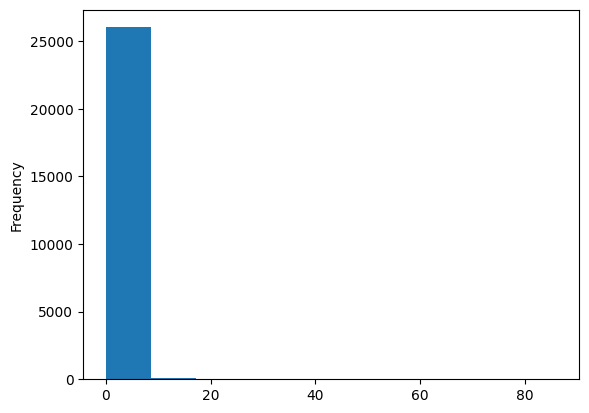

In [88]:
col_metrics(ntsb_4, 'inj_tot_t') 

In [89]:
# Column 69: Wind_vel_ind

# Drop the two rows that have nulls for column 69 - wind_vel_ind
ntsb_4 = ntsb_4.dropna(subset=['wind_vel_ind'])

#Change data type to string
ntsb_4['wind_vel_ind'] = ntsb_4['wind_vel_ind'].astype('string')

<ipython-input-89-ed95feb0f7e9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ntsb_4['wind_vel_ind'] = ntsb_4['wind_vel_ind'].astype('string')


In [90]:
# column 71: gust_kts   

print(ntsb_4.sort_values('gust_kts'))

      wind_vel_ind gust_ind  gust_kts  altimeter  wx_dens_alt wx_int_precip  \
0              UNK        U       0.0        NaN          NaN           UNK   
36386          UNK        N       0.0        NaN          NaN           UNK   
36387         CALM        N       0.0        NaN          NaN           UNK   
36388          UNK        N       0.0  29.000000          NaN           UNK   
36390          UNK        N       0.0  30.000000          NaN           LGT   
...            ...      ...       ...        ...          ...           ...   
52098         SPEC        N       NaN  30.200001          NaN           NaN   
52099         SPEC        N       NaN  30.290001          NaN           NaN   
52100         SPEC        N       NaN  30.219999          NaN           NaN   
52101         SPEC        N       NaN  30.290001          NaN           NaN   
52110         SPEC        N       NaN  29.870001          NaN           NaN   

      ev_highest_injury  inj_tot_t wx_cond_basic Ca

In [91]:
# column 74: wx_int_precip     

# May have to drop this column since only about 18% of values or 101004 out of 104... are not null or unknown
ntsb_4['wx_int_precip'] = ntsb_4['wx_int_precip'].fillna("UNK")
print(ntsb_4['wx_int_precip'].isna().sum())

print('updated null count:', ntsb_4['wx_int_precip'].isna().sum())

0
updated null count: 0


In [92]:
# column 77: wx_cond_basic

# Replace 'Unk' with 'UNK' to match the values in wx_cond_basic columns   
ntsb_4['wx_cond_basic'] = ntsb_4['wx_cond_basic'].str.replace('Unk', 'UNK')
# Drop the remaining nulls
ntsb_4 = ntsb_4.dropna(subset=['wx_cond_basic'])

In [93]:
# convert data types to string
ntsb_4['gust_ind'] = ntsb_4['gust_ind'].astype('string')
ntsb_4['wx_int_precip'] = ntsb_4['wx_int_precip'].astype('string')
ntsb_4['ev_highest_injury'] = ntsb_4['ev_highest_injury'].astype('string')
ntsb_4['wx_cond_basic'] = ntsb_4['wx_cond_basic'].astype('string')
ntsb_4['Cause_Factor'] = ntsb_4['Cause_Factor'].astype('string')
ntsb_4['crew_category'] = ntsb_4['crew_category'].astype('string')
ntsb_4['crew_sex'] = ntsb_4['crew_sex'].astype('string')
ntsb_4['med_certf'] = ntsb_4['med_certf'].astype('string')
ntsb_4['pilot_flying'] = ntsb_4['pilot_flying'].astype('string')
ntsb_4['crew_inj_level'] = ntsb_4['crew_inj_level'].astype('string')

<ipython-input-93-ce0e6179a39e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ntsb_4['gust_ind'] = ntsb_4['gust_ind'].astype('string')
<ipython-input-93-ce0e6179a39e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ntsb_4['wx_int_precip'] = ntsb_4['wx_int_precip'].astype('string')
<ipython-input-93-ce0e6179a39e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [94]:
# Drop unnecessary columns
ntsb_4 = ntsb_4.drop('Cause_Factor', axis=1)

In [95]:
ntsb_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61645 entries, 0 to 104119
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   wind_vel_ind       61645 non-null  string 
 1   gust_ind           61630 non-null  string 
 2   gust_kts           55215 non-null  float64
 3   altimeter          49066 non-null  float64
 4   wx_dens_alt        18262 non-null  float64
 5   wx_int_precip      61645 non-null  string 
 6   ev_highest_injury  61633 non-null  string 
 7   inj_tot_t          34934 non-null  float64
 8   wx_cond_basic      61645 non-null  string 
 9   crew_no            11667 non-null  float64
 10  crew_category      11584 non-null  string 
 11  crew_age           11248 non-null  float64
 12  crew_sex           8665 non-null   string 
 13  med_certf          11193 non-null  string 
 14  pilot_flying       61188 non-null  string 
 15  crew_inj_level     11347 non-null  string 
dtypes: float64(6), string

## Save final copy of data set

In [96]:
ntsb_4.to_csv('cleaned_ntsb.csv')